<table style="border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9; width: 95%; margin-bottom: 20px;" align="left">
  <tr>
    <td style="padding: 15px; text-align: center;">
      <a target="_blank" href="https://github.com/AbdallaNassar">
        <img src="https://raw.githubusercontent.com/detain/svg-logos/b02ee1ac30c7ff4757278337c95588b01ed0954b/svg/g/github-icon-2.svg" width="50px" alt="GitHub" />
      </a>
    </td>
    <td style="padding: 15px; text-align: center;">
      <a target="_blank" href="https://abdallanassar.me/">
        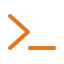
      </a>
    </td>
    <td style="padding: 15px; text-align: center;">
      <a target="_blank" href="https://www.kaggle.com/abdallanassar25">
        <img src="https://www.vectorlogo.zone/logos/kaggle/kaggle-ar21.svg" width="150px" alt="Kaggle" />
      </a>
    </td>
  </tr>
</table>


## If you need use GUI only

<h1>load first 3 Cells and GUI and Logic Cells</h1>

---



# Initialization

## Importing libraries


In [ ]:
# Update packages
! pip install -U langchain_community tiktoken faiss-cpu langchain langchainhub sentence_transformers BeautifulSoup4 -q

# Install pypdf
! pip install pypdf -q

# Install langchain-huggingface
! pip install langchain-huggingface -q

# Upgrade langchain and langchain-google
! pip install --upgrade langchain langchain-google-q

# Install langchain-google-genai version
!pip install langchain_google_genai -q

# # Install google-generativeai
! pip install google-generativeai-q
! pip install gradio -q


In [2]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough
from langchain.vectorstores import Chroma
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
import gradio as gr
import os,re

## Generative AI setup


In [3]:
# Initialize ChatGoogleGenerativeAI for generative AI chat
def get_llm(model_name):
    return ChatGoogleGenerativeAI(
        model=model_name,
        temperature=0.1,
        max_output_tokens=500,
        google_api_key= "your_api_key_here" 
    )

template = """You are an expert AI instructor tasked with evaluating student answers. Use the following reference information to assess the student's answer:

Reference Information: {context}

Question: {question}

Student's Answer: {student_answer}

Evaluate the student's answer based on the reference information. Provide:
1. A numerical grade out of 10
2. A letter grade based on the following scale:
   9-10: A+
   8-8.9: A
   7-7.9: B+
   6-6.9: B
   5-5.9: C+
   4-4.9: C
   3-3.9: D+
   2-2.9: D
   0-2.9: F
3. Detailed feedback explaining the rating
4. Suggestions for improvement

Your response should be in the following format:
Numerical Grade: [Your grade out of 10]
Letter Grade: [Corresponding letter grade]
Feedback: [Your detailed feedback]
Suggestions: [Your suggestions for improvement]

Please provide your response in {language}. When responding in Arabic i need response like this

Numerical Grade= Numerical Grade: 10
Letter Grade= Letter Grade: A+
Feedback= Feedback: الاجابه بالعربي
Suggestions= Suggestions: الاجابه بالعربي
"""

prompt = ChatPromptTemplate.from_template(template)

## Loading PDF

In [ ]:
# Initialize the PyPDFLoader with your PDF file path
loader = PyPDFLoader("/content/Understanding Artificial Intelligence.pdf")

# Load the data from the PDF
data = loader.load()


## Splitting documents


In [ ]:
# Initialize the RecursiveCharacterTextSplitter with desired chunk parameters
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)

# Split the document into chunks
all_splits = text_splitter.split_documents(data)

## Embeddings and vector store creation


In [ ]:
# Initialize HuggingFaceEmbeddings with the model name
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Create FAISS vector store from documents and embeddings
vectorstore = FAISS.from_documents(documents=all_splits, embedding=embeddings)

# Convert vector store to a retriever
retriever = vectorstore.as_retriever()

# Processing

## Similarity search


In [ ]:
# Perform similarity search with the question
question = "What is Artificial Intelligence?"
docs = vectorstore.similarity_search(question)

# Get the number of documents retrieved
num_docs = len(docs)

print(f"Number of documents retrieved: {num_docs}")

Number of documents retrieved: 4


In [ ]:
docs[0]

Document(metadata={'source': '/content/Understanding Artificial Intelligence.pdf', 'page': 1}, page_content='Introduction to Artificial Intelligence \nDefinition of Artificial Intelligence (AI): \nAI refers to the simulation of human intelligence in machines that are programmed \nto think and learn like humans. It encompasses a variety of technologies that \nenable machines to perform tasks that typically require human intelligence.')

## Chaining processes


In [ ]:
# Define a function to format retrieved documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define a function to combine retriever results with input
def combine_inputs(input_dict):
    question = input_dict["question"]
    retrieved_docs = retriever.get_relevant_documents(question)
    formatted_context = format_docs(retrieved_docs)
    return {
        "context": formatted_context,
        "question": question,
        "student_answer": input_dict["student_answer"]
    }

# Chain
chain = (
    RunnablePassthrough()
    | combine_inputs
    | prompt
    | llm
    | StrOutputParser()
)

## Example

In [ ]:
# Example usage
question = "Compare and contrast machine learning with traditional programming approaches. In what scenarios is machine learning more advantageous, and what limitations does it have compared to conventional programming methods?"
student_answer = "Machine learning (ML) represents a shift from traditional programming methods. In traditional programming, developers write explicit instructions for the computer to follow. In contrast, ML algorithms learn from data and can adapt over time. This makes ML particularly effective for tasks like speech recognition and image classification. However, ML requires large datasets and can be sensitive to the quality of the data it learns from, which can lead to issues like overfitting."

result = chain.invoke({"question": question, "student_answer": student_answer})

In [ ]:
result


'Grade: 7/10\n\nFeedback: The student demonstrates a good understanding of the fundamental differences between machine learning and traditional programming. They accurately highlight the key aspects of both approaches, including the reliance on explicit instructions in traditional programming versus data-driven learning in ML. The student also correctly identifies the strengths of ML in handling complex tasks like speech recognition and image classification. \n\nThe answer further acknowledges a significant limitation of ML, namely the need for large datasets and the potential for overfitting. However, the explanation could be more detailed. \n\nSuggestions:\n\n* **Expand on the limitations:**  The student mentions overfitting but could elaborate on other limitations like the "black box" nature of ML models (difficulty in understanding the decision-making process), the need for specialized expertise in ML, and the potential for bias in the training data.\n* **Provide specific examples:

## Extracting Grade, Feedback, and Suggestions


In [ ]:
# Extract grade, feedback, and suggestions
grade = result.split('Feedback:')[0].strip()
feedback = result.split('Feedback:')[1].split('Suggestions:')[0].strip()
suggestions = result.split('Suggestions:')[1].strip()

# Print extracted values
print(f"Grade: {grade}")
print(f"Feedback: {feedback}")
print(f"Suggestions: {suggestions}")

Grade: Grade: 7/10
Feedback: The student demonstrates a good understanding of the fundamental differences between machine learning and traditional programming. They accurately highlight the key aspects of both approaches, including the reliance on explicit instructions in traditional programming versus data-driven learning in ML. The student also correctly identifies the strengths of ML in handling complex tasks like speech recognition and image classification. 

The answer further acknowledges a significant limitation of ML, namely the need for large datasets and the potential for overfitting. However, the explanation could be more detailed.
Suggestions: * **Expand on the limitations:**  The student mentions overfitting but could elaborate on other limitations like the "black box" nature of ML models (difficulty in understanding the decision-making process), the need for specialized expertise in ML, and the potential for bias in the training data.
* **Provide specific examples:**  Ins

# GUI

## Logic

In [4]:

# Define a function to process the input and generate the output
def predict(pdf_file, question, student_answer, model_name, grade_type, language):
    # Load the PDF
    loader = PyPDFLoader(pdf_file.name)
    data = loader.load()

    # Split the document into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
    all_splits = text_splitter.split_documents(data)

    # Create FAISS vector store from documents and embeddings
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(documents=all_splits, embedding=embeddings)
    retriever = vectorstore.as_retriever()

    # Define a function to format retrieved documents
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Define a function to combine retriever results with input
    def combine_inputs(input_dict):
        question = input_dict["question"]
        retrieved_docs = retriever.get_relevant_documents(question)
        formatted_context = format_docs(retrieved_docs)
        return {
            "context": formatted_context,
            "question": question,
            "student_answer": input_dict["student_answer"],
            "language": input_dict["language"]
        }

    # Get the LLM based on the selected model
    llm = get_llm(model_name)

    # Chain
    chain = (
        RunnablePassthrough()
        | combine_inputs
        | prompt
        | llm
        | StrOutputParser()
    )

    # Invoke the chain
    output = chain.invoke({"question": question, "student_answer": student_answer, "language": language})

    patterns = {
        'numerical_grade': r'Numerical Grade:\s*([\d.]+)',
        'letter_grade': r'Letter Grade:\s*([A-F][+]?)',
        'feedback': r'Feedback:\s*(.+?)(?=\n\S|$)',
        'suggestions': r'Suggestions:\s*(.+?)(?=\n\S|$)'
    }

    # Extract information using regex
    extracted_info = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, output, re.DOTALL)
        extracted_info[key] = match.group(1).strip() if match else 'Information not found'

    # Select the grade based on user choice
    grade = extracted_info['numerical_grade'] if grade_type == "Numerical Grade" else extracted_info['letter_grade']

    # Prepare the output
    feedback = extracted_info['feedback']
    suggestions = extracted_info['suggestions']

    # If no structured information was found, return the raw output
    if all(value == 'Information not found' for value in extracted_info.values()):
        grade = "Unable to parse grade"
        feedback = "Unable to parse feedback. Raw output:\n\n" + output
        suggestions = "Unable to parse suggestions"

    return grade, feedback, suggestions, model_name


## Gui

In [5]:

# Create Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.File(label="Upload PDF"),
        gr.Textbox(label="Question"),
        gr.Textbox(label="Student Answer"),
        gr.Dropdown(
            choices=["gemini-1.5-flash", "gemini-1.0-pro","gemini-1.5-pro"],
            label="Select Gemini Model , If you use Arabic make model is gemini-1.5-flash",
            value="gemini-1.5-flash"
        ),
        gr.Radio(
            choices=["Numerical Grade", "Letter Grade"],
            label="Grade Type",
            value="Numerical Grade"
        ),
        gr.Radio(
            choices=["English", "Arabic"],
            label="Language",
            value="English"
        )
    ],
    outputs=[
        gr.Textbox(label="Grade"),
        gr.Textbox(label="Feedback"),
        gr.Textbox(label="Suggestions")
    ],
    title="AI-Powered Student Assessment",
    description="Evaluate student answers using AI models and provide grades, feedback, and suggestions."
)

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://47c771a00b7ff0bb50.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
